1. $$y(x)=\sum_{n=1}^Na_nt_nk(x,x_n)+b$$
2. $$ \text{if }y1\neq y2 \text{ then } L=max(0,a_2^{old}),H=min(C,C+a_2^{old}-a_1^{old})$$
3. $$ \text{if }y1=y2\text{ then } L=max(0,a_2^{old}+a_1^{old}-C),H=min(C,a_2^{old}+a_1^{old})$$
4. $$\eta = K_{11}+K_{22}-2K_{12}$$
5. $$a_2^{new,unc}=a_2^{old}+\frac{y_2(E_1-E_2)}{\eta}$$
6. $$a_1^{new}=a_1^{old}+y_1y_2(a_2^{old}-a_2^{new})$$
7. $$b_1^{new}=-E_1-y_1K_{11}(a_1^{new}-a_1^{old})-y_2K_{21}(a_2^{new}-a_2^{old})+b^{old}$$
8. $$b_2^{new}=-E_2-y_1K_{12}(a_1^{new}-a_1^{old})-y_2K_{22}(a_2^{new}-a_2^{old})+b^{old}$$

In [2]:
import numpy as np
#SMO算法中的辅助函数
def loadDataSet(fileName):
    dataMat = [];labelMat=[]
    fr = open(fileName)
    for line in fr.readlines():
        lineArr=line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    return j
def clipAlpha(aj,H,L):
    if aj>H:
        aj = H
    if L>aj:
        aj = L
    return aj

In [9]:
#dataMatIn-训练样本 classLabels-每个训练样本对应的标签 C-an的上限 toler-误差门限 maxlter-迭代次数
def smoSimple(dataMatIn, classLabels, C, toler, maxlter):
    dataMat = np.mat(dataMatIn);
    labelMat = np.mat(classLabels).transpose()
    b = 0;m,n = np.shape(dataMat) # m个样本n个特征
    alphas = np.mat(np.zeros((m,1)))
    myiter = 0
    while(myiter < maxlter):
        alphaPairsChanged = 0
        for i in range(m): # 顺序选择第一个样本点
            fXi = float(np.multiply(alphas,labelMat).T*(dataMat*dataMat[i,:].T)) + b #①
            Ei = fXi - float(labelMat[i])
            # 检查是否破坏了KKT条件,两个方向检查，确保an不会突破上下限
            if((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i]>0)):
                j = selectJrand(i,m) #随机选择另一个样本点
                fXj = float(np.multiply(alphas,labelMat).T*(dataMat*dataMat[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                oldI = alphas[i].copy();oldJ = alphas[j].copy();
                if(labelMat[i]!=labelMat[j]): #2
                    L=max(0,alphas[j]-alphas[i])
                    H=min(C,C+alphas[j]-alphas[i])
                else:#3
                    L=max(0,alphas[j]+alphas[i]-C)
                    H=min(C,alphas[j]+alphas[i])
                if L==H:print('L==H');continue
                   # 这里其实算的是-eta
                eta = 2.0*dataMat[i,:]*dataMat[j,:].T-dataMat[i,:]*dataMat[i,:].T-dataMat[j,:]*dataMat[j,:].T#4
                if eta>=0:print('eta>0');continue
                alphas[j] -= labelMat[j]*(Ei-Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if(abs(alphas[j]-oldJ)<0.00001):print('j not moving enough');continue
                alphas[i] += labelMat[j] * labelMat[i]*(oldJ-alphas[j])#6
                b1=b-Ei-labelMat[i]*(alphas[i]-oldI)*dataMat[i,:]*dataMat[i,:].T-\
                labelMat[j]*(alphas[j]-oldJ)*dataMat[i,:]*dataMat[j,:].T#7
                b2=b-Ej-labelMat[i]*(alphas[i]-oldI)*dataMat[i,:]*dataMat[j,:].T-\
                labelMat[j]*(alphas[j]-oldJ)*dataMat[j,:]*dataMat[j,:].T#8
               # 如果都满足条件则 b1_new=b2_new，反之选择他们的中点作为b_new
                if(0<alphas[i]) and (C>alphas[i]):b=b1
                elif (0<alphas[j]) and (C>alphas[j]):b=b2
                else :b=(b1+b2)/2.0
                alphaPairsChanged +=1
                print('iter: {} i: {},pairs changed {}'.format(myiter,i,alphaPairsChanged))
        if(alphaPairsChanged == 0): myiter+=1
        else: myiter = 0
        print('iteration number: {}'.format(myiter))
    return b,alphas

In [10]:
dataArr,labelArr=loadDataSet('testSet.txt')

In [ ]:
b,alphas=smoSimple(dataArr,labelArr,0.6,0.001,40)

In [12]:
b

matrix([[-3.82372018]])

In [13]:
alphas[alphas>0]

matrix([[0.11967661, 0.2401375 , 0.00219581, 0.3576183 ]])

<IPython.core.display.Javascript object>


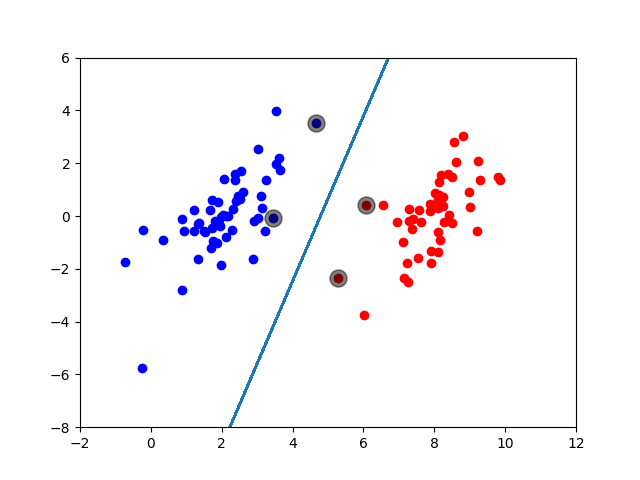

In [16]:
import matplotlib.pyplot as plt
plotAns(b,alphas)

In [1]:
def calcWs(alphas,dataArr,classLabels):
    x=np.mat(dataArr);labelmat=np.mat(classLabels).transpose()
    m,n=np.shape(x)
    w=np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelmat[i],x[i,:].T)
    return w
    

In [3]:
#完整的SMO支持函数
class optStruct:
    def __init__(self,dataMatIn,classLabels,C,toler,KTup):
        self.x=dataMatIn
        self.c=C
        self.labelMat=classLabels
        self.tol=toler
        self.m=np.shape(dataMatIn)[0]
        self.alphas=np.mat(np.zeros((self.m,1)))
        self.b=0
        self.eCache=np.mat(np.zeros((self.m,2)))
        self.K=np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i]=kernelTrans(self.x,self.x[i,:],KTup)
        
def calcEk(oS,k):
    fxk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k]+oS.b)
    #fxk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek=fxk-float(oS.labelMat[k])
    return Ek
def selectJ(i,oS,Ei):
    maxK=-1;maxDeltaE=0;Ej=0
    oS.eCache[i]=[1,Ei]
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0]
    if(len(validEcacheList))>1:
        for k in validEcacheList:
            if k==i:continue
            Ek=calcEk(oS,k)
            deltaE=abs(Ei-Ek)
            if(deltaE>maxDeltaE):
                maxK=k;maxDeltaE=deltaE;Ej=Ek
        return maxK,Ej
    else:
        j=selectJrand(i,oS.m)
        Ej=calcEk(oS,j)
    return j,Ej
def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.eCache[k]=[1,Ek]
def kernelTrans(x,A,ktup):
    m,n=np.shape(x)
    k=np.mat(np.zeros((m,1)))
    if ktup[0]=='lin':k=x*A.T #线性核函数,我们还是用线性核函数 f(x)=x
    elif ktup[0]=='rbf':
        for j in range(m):
            deltaRow = x[j,:]-A
            k[j]=deltaRow*deltaRow.T
        k=np.exp(k/(-1*ktup[1]**2))
    else:raise NameError('Houston we have a problem--Thatkernel is not recognized')
    return k

In [4]:
def innerL(i,oS):
    Ei=calcEk(oS,i)
    if((oS.labelMat[i]*Ei<-oS.tol) and (oS.alphas[i]<oS.c)) or ((oS.labelMat[i]*Ei>oS.tol) and (oS.alphas[i]>0)):
        j,Ej=selectJ(i,oS,Ei)#与selectJrand的方法不同
        old_i=oS.alphas[i].copy();old_j=oS.alphas[j].copy()
        if(oS.labelMat[i]!=oS.labelMat[j]):
            L=max(0,oS.alphas[j]-oS.alphas[i])
            H=min(oS.c,oS.c+oS.alphas[j]-oS.alphas[i])
        else:
            L=max(0,oS.alphas[j]+oS.alphas[i]-oS.c)
            H=min(oS.c,oS.c+oS.alphas[j]+oS.alphas[i])
        if L==H:print('L==H');return 0
        eta=2.0*oS.K[i,j]-oS.K[i,i]-oS.K[j,j]#根据核函数计算eta
        if(eta>=0):print('eta>=0');return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei-Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if(abs(oS.alphas[j]-old_j)<0.00001):print('j not moving enough');return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(old_j-oS.alphas[j])
        updateEk(oS,i)
        b1=oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-old_i)*oS.K[i,i]-oS.labelMat[j]*(oS.alphas[j]-old_j)*oS.K[i,j]
        b2=oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-old_i)*oS.K[i,j]-oS.labelMat[j]*(oS.alphas[j]-old_j)*oS.K[j,j]
        if(0<oS.alphas[i]) and (oS.c>oS.alphas[i]):oS.b=b1
        elif(0<oS.alphas[j]) and (oS.c>oS.alphas[j]):oS.b=b2
        else:oS.b=(b1+b2)/2.0
        return 1
    else: return 0        

In [19]:
def smoP(dataMatIn,classLabels,C,toler,maxIter,Ktup=('lin',0)):
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler,Ktup)
    myiter=0
    entireSet = True;changeflag=0
    while(myiter<maxIter) and ((changeflag > 0) or (entireSet)):
        changeflag=0
        if entireSet:
            for i in range(oS.m):
                changeflag+=innerL(i,oS)
                print("fullSet,iter:{} i:{},pairs changed {}".format(myiter,i,changeflag))
            myiter+=1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A>0)*(oS.alphas.A<C))[0]
            for i in nonBoundIs:
                changeflag+=innerL(i,oS)
                print('non-bound,iter:{} i:{},pairs changed {}'.format(myiter,i,changeflag))
            myiter+=1
        if entireSet:entireSet=False
        elif(changeflag==0):entireSet = True
        print("iteration number {}".format(myiter))
    return oS.b,oS.alphas
            

In [ ]:
b,alpha=smoP(dataArr,labelArr,0.6,0.001,40)

In [21]:
def plotAns(b,alphas):
    x_support=[];y_support=[]
    for i in range(100):
        if alphas[i]>0.0:
            x_support.append(dataArr[i][0])
            y_support.append(dataArr[i][1])
    ws = calcWs(alphas,dataArr,labelArr)
    x=[dataArr[i][0] for i in range(len(dataArr))]
    y=[dataArr[i][1] for i in range(len(dataArr))]
    x1=[];x2=[];y1=[];y2=[]
    for i in range(len(dataArr)):
        if labelArr[i]==1.0:
            x1.append(x[i])
            y1.append(y[i])
        else: 
            x2.append(x[i])
            y2.append(y[i])
    line_x2=[]
    for i in range(len(x)):
        line_x2.append(float((-ws[0]/ws[1])*x[i]-b/ws[1]))
    %matplotlib notebook
    plt.axis([-2,12,-8,6])
    plt.scatter(x2,y2,c='b')
    plt.scatter(x1,y1,c='r')
    plt.scatter(x_support, y_support,s=150,c='black',marker='o',alpha=0.5)
    plt.plot(x,line_x2)

<IPython.core.display.Javascript object>


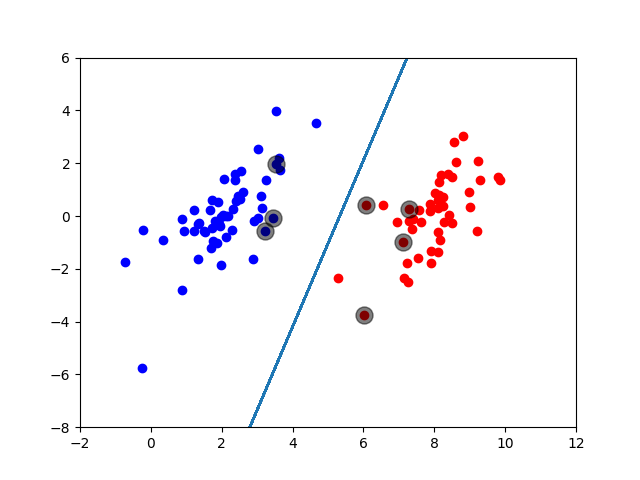

In [22]:
plotAns(b,alpha)

In [108]:
def img2vector(filename):
    returnVect=np.zeros((1,1024))
    fr=open(filename)
    for i in range(32):
        lineStr=fr.readline()
        for j in range(32):
            returnVect[0,32*i+j]=int(lineStr[j])
    return returnVect
def loadImages(dirName):
    from os import listdir
    hwlabel=[]
    trainingFileList=listdir(dirName)
    m=len(trainingFileList)
    trainingMat=np.zeros((m,1024))
    for i in range(m):
        fileNameStr=trainingFileList[i]
        fileStr=fileNameStr.split('.')[0]
        classNumStr=int(fileStr.split('_')[0])
        if classNumStr == 9:hwlabel.append(-1)
        else: hwlabel.append(1)
        trainingMat[i,:]= img2vector('%s%s' % (dirName,fileNameStr))
    return trainingMat,hwlabel
def testDigits(ktup=('rbf',10)):
    dataArr,labelArr=loadImages('digits/trainingDigits/')
    b,alphas=smoP(dataArr,labelArr,200,0.0001,10000,ktup)
    dataMat=np.mat(dataArr);labelMat=np.mat(labelArr).transpose()
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=dataMat[svInd]
    labelSV=labelMat[svInd]
    print("支持向量数量为:{}".format(np.shape(sVs)[0]))
    m,n=np.shape(dataMat)
    errorCount=0
    for i in range(m):  
        kernelEval=kernelTrans(sVs,dataMat[i,:],ktup)
        predict=kernelEval.T*np.multiply(labelSV,alphas[svInd])+b
        if np.sign(predict) != np.sign(labelArr[i]):errorCount += 1
    print('训练集的错误率为:{}'.format(float(errorCount)/m))
    dataArr,labelArr=loadImages('digits/testDigits/')
    errorCount=0
    dataMat=np.mat(dataArr);labelMat=np.mat(labelArr).transpose()
    m,n=np.shape(dataMat)
    for i in range(m):
        kernelEval=kernelTrans(sVs,dataMat[i,:],ktup)
        predict=kernelEval.T*np.multiply(labelSV,alphas[svInd])+b
        if np.sign(predict) != np.sign(labelArr[i]):errorCount += 1
    print('测试集的错误率为:{}'.format(float(errorCount)/m))

In [ ]:
testDigits()
# 支持向量数量为:129
# 训练集的错误率为:0.0
# 测试集的错误率为:0.005376344086021506